# 16018942 Assignment 3

### Table of Contents
1. [Question 1](#question1)
2. [Question 2](#question2)

###### N.B Notebook runs in $\approx 50s$ on computer used for development (Ubuntu 18.04.3 LTS, Intel® Core™ i7-6600U CPU @ 2.60GHz × 4) and formatting has been checked with autopep8 (https://pypi.org/project/autopep8/)

In [1]:
# Importing libraries.
import pyopencl as cl
import numpy as np
import scipy as sp
from scipy import sparse
from scipy import linalg
from scipy.sparse.linalg import LinearOperator,aslinearoperator,cg,spilu,splu
from scipy.sparse import csr_matrix, coo_matrix, random, vstack, hstack
from numba import njit,prange,jit,jitclass
import sys

import matplotlib.pyplot as plt
from scipy.sparse import csgraph
from scipy.optimize import newton_krylov

# Magic command to keep plots in the notebook.
%matplotlib inline

In [2]:
# Importing library and setting up class for timing performance.
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [3]:
def residual_calc(solution,b):
    '''Function to compute residual as per
    assignmnet documentation.'''
    
    return np.linalg.norm(b-solution)/np.linalg.norm(b)

# Question 1
<a id="question1"></a>

## Jacobi

Start with class for Laplacian from previous assignment.

In [4]:
class Laplacian_OpenCL(LinearOperator): 
    '''This class represents a Laplacian LinearOperator.'''
    def __init__(self,m):
        '''Constructor for creating Laplacian instance.'''
        
        self.m = m
        self.shape = (m * m, m * m)

        # Setup OpenCL.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        # OpenCL kernel for 5 point laplician 
        # stencil approximation.
        self.prg = cl.Program(self.ctx, """
            __kernel void operator(const int N,
                                      const __global float* entry,
                                      __global float* results) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);
                const int anti_separation = (N+1)*(N+1);
                
                float mid = entry[N*i + j];
                float top = entry[N*(i-1) + j];
                float bottom = entry[N*(i+1) + j];
                float minus = entry[N*i + j-1];
                float plus = entry[N*i + j+1];
                
                if (i == 0){
                    top = 0;
                }
                if (i == (N-1)){
                    bottom = 1;
                }
                if (j == 0){
                    minus = 0;
                }
                if (j == (N-1)){
                    plus = 0;
                }
                
                results[N*i + j] = (
                4*mid - top - bottom - minus - plus)*anti_separation;
            }
            """).build()
        
        
    def _matvec(self,line_data):
        '''This function represents the matrix multiplication for the laplacian.'''

        # Setting up class data type.
        self.dtype = line_data.dtype
        
        N = np.int32(self.m)
        
        # Setting up array for results. 
        results = np.zeros_like(line_data).astype('float32')
        
        # Setting up on device storage.
        grid_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=line_data)
        results_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, line_data.nbytes)

        linoperator = self.prg.operator

        ts = 1
        
        # Running OpenCL program for given inputs.
        event = linoperator(
            self.queue, (N, N), (ts, ts), N, grid_device, results_device)
        event.wait()

        cl.enqueue_copy(self.queue, results, results_device)
        event.wait()
        self.queue.finish()

        return results
    
    def create(self):
        '''Function to create instant of object as scipy LinearOperator.'''
            
        return LinearOperator((self.m,self.m),matvec=self._matvec)

Functions for solving and plotting the system.

In [5]:
def b_of_system(M):
    '''Function to create b part of system.'''
    return np.zeros((M*M), dtype='float32')

In [6]:
def plot_laplace_CG(iterations,M):
    '''Function to compute and plot solution u.'''
    
    laplacian = Laplacian_OpenCL(M)
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M)
    # CG solver.
    with Timer() as t:
        solution,info = cg(
            laplacian,b_of_system(M),
            maxiter = iterations, callback = cg_call_back,x0=np.ones((M*M), dtype='float32'))
    print("Time to run with: {0}".format(t.interval))
    
    
    plt.figure(figsize=(8,8))
    plt.imshow(
        solution.reshape(M,M), cmap='viridis',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of solution $u$ on domain for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()

Now output the result of the laplacian.

Time to run with: 0.16731858253479004


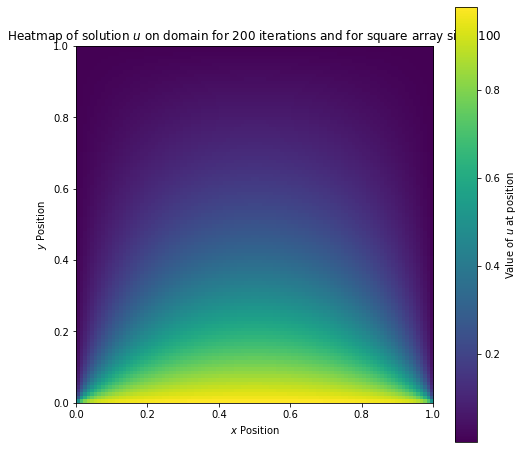

In [7]:
plot_laplace_CG(200,100)

So this is, for the boundary conditions that are set, the solution we are looking for. 
Thus starting from the class used above we modify the class to use the Jacobi iteration

In [8]:
class Laplacian_OpenCL_Jacobi(LinearOperator): 
    '''This class represents a Jacobi teration.'''
    def __init__(self,m):
        '''Constructor for creating Jacobi instance.'''

        self.m = m
        self.shape = (m * m, m * m)

        # Setup OpenCL.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        # OpenCL kernel for jacobi.
        self.prg = cl.Program(self.ctx, """
            __kernel void operator(const int N,
                                      const __global float* entry,
                                      __global float* results) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);
                
                float mid = entry[N*i + j];
                float top = entry[N*(i-1) + j];
                float bottom = entry[N*(i+1) + j];
                float minus = entry[N*i + j-1];
                float plus = entry[N*i + j+1];
                
                if (i == 0){
                    top = 0;
                }
                if (i == (N-1)){
                    bottom = 1;
                }
                if (j == 0){
                    minus = 0;
                }
                if (j == (N-1)){
                    plus = 0;
                }
                
                results[N*i + j] = (
                top + bottom + minus + plus)*0.25;
            }
            """).build()
        
        
    def _matvec(self,line_data):
        '''This function represents the matrix multiplication for the jacobi.'''

        # Setting up class data type.
        self.dtype = line_data.dtype
        
        N = np.int32(self.m)
        
        # Setting up array for results. 
        results = np.zeros_like(line_data).astype('float32')
        
        # Setting up on device storage.
        grid_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=line_data)
        results_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, line_data.nbytes)

        linoperator = self.prg.operator

        ts = 1
        
        # Running OpenCL program for given inputs.
        event = linoperator(
            self.queue, (N, N), (ts, ts), N, grid_device, results_device)
        event.wait()

        cl.enqueue_copy(self.queue, results, results_device)
        event.wait()
        self.queue.finish()

        return results
    
    def create(self):
        '''Function to create instant of object as scipy LinearOperator.'''
            
        return LinearOperator((self.m,self.m),matvec=self._matvec)

Then write function for solving and plotting the solution of the system.

In [9]:
def plot_laplace_CG_Jacobi(iterations,M):
    '''Function to compute and plot solution u.'''
    
    laplacian = Laplacian_OpenCL_Jacobi(M)
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M)
        
    initial_guess = np.zeros((M*M),dtype='float32')
    
    residual = []
    
    # Timing performance.    
    with Timer() as t:
    
        for n in range(0,iterations):
            solution_n = laplacian._matvec(initial_guess)
            initial_guess = solution_n

            residual.append(np.linalg.norm(solution_n))
    print("Time to run with: {0}".format(t.interval))
    
    plt.figure(figsize=(8,8))
    plt.imshow(
        solution_n.reshape(M,M), cmap='viridis',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of jacobi solution $u$ on domain \n for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()
    
    plt.figure()
    plt.plot(np.linspace(1,iterations,num=iterations-1),np.diff(residual))
    plt.axhline(y=0,color='m')
    plt.title(
        'Convergence of $u$ across iterations on domain \n for max '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('Iterations')
    plt.ylabel('Solution step difference')
    #plt.yscale('log')

Using that function.

Time to run with: 0.4227621555328369


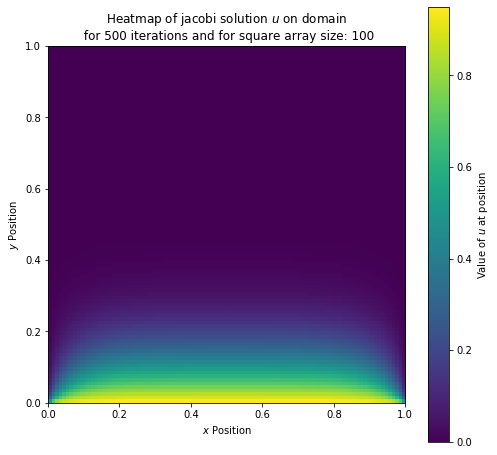

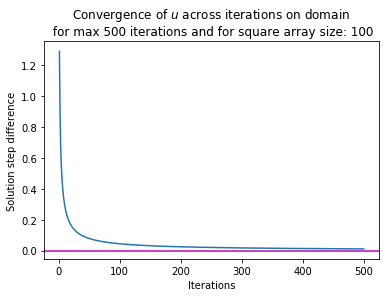

In [10]:
plot_laplace_CG_Jacobi(500,100)

We can see from the convergence plot that the difference in the solutions quickly decreases, and then begins to level off, approaching a zero difference ever more gradually with the increase in iteration number. This indicates the convergence of the iterations as once the blue line reaches the zero magenta line the iterations are not changing the solution. The opton to plot the y scale as log is left in but commented out as t was harder to see the convergence of the step difference to the zero level (i.e. magenta line is not present when log scale on y axis is in use.

## Gauss-Seidel

To start we use numba for optimisation purposes (parralellising the loops using 'prange').

We define two function for running Gauss-Seidel method (one from the bottom of the matrix to the top and the antithesis).

In [11]:
@njit
def gauss_seiddel_UP(M,vec):
    '''Functon for Gauss Seiddel iteration in
    increasing index direction.'''
    N=M
    entry = vec
    results = vec
    for i in prange(M):
        for j in prange(M):
            
                
            mid = entry[N*i + j]
                
            if (i == 0):
                top = 0;
            else:
                top = entry[N*(i-1) + j]
            if (i == (N-1)):
                bottom = 1;
            else:
                bottom = entry[N*(i+1) + j]
            if (j == 0):
                minus = 0
            else:
                minus = entry[N*i + j-1]
            if (j == (N-1)):
                plus = 0
            else:
                plus = entry[N*i + j+1]
                
            results[N*i + j] = (top + bottom + minus + plus)*0.25
            entry[N*i + j] = (top + bottom + minus + plus)*0.25
    return results

In [12]:
@njit
def gauss_seiddel_DOWN(M,vec):
    '''Function for Gauss Seiddel teration in
    increasing index direction.'''
    N=M
    entry = vec
    results = vec
    for i in prange(M-1,-1,-1):
        for j in prange(M):     
                
            mid = entry[N*i + j]
                
            if (i == 0):
                top = 0;
            else:
                top = entry[N*(i-1) + j]
            if (i == (N-1)):
                bottom = 1;
            else:
                bottom = entry[N*(i+1) + j]
            if (j == 0):
                minus = 0
            else:
                minus = entry[N*i + j-1]
            if (j == (N-1)):
                plus = 0
            else:
                plus = entry[N*i + j+1]
                
            results[N*i + j] = (top + bottom + minus + plus)*0.25
            entry[N*i + j] = (top + bottom + minus + plus)*0.25
    return results

In [13]:
def plot_laplace_CG_Gauss_Numba_UP(iterations,M):
    '''Function to compute and plot solution u
    from the Numba accelerated Gauss Seiddel Up iteration.'''
    
    initial_guess = np.zeros((M*M),dtype='float32')
    
    with Timer() as t:

        for n in range(0,iterations):
            solution_n = gauss_seiddel_UP(M,initial_guess)
            initial_guess = solution_n
    print("Time to run with: {0}".format(t.interval))

    plt.figure(figsize=(8,8))
    plt.imshow(
        initial_guess.reshape(M,M), cmap='viridis',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of Gauss Up solution $u$ on domain \n for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()

In [14]:
def plot_laplace_CG_Gauss_Numba_DOWN(iterations,M):
    '''Function to compute and plot solution u
    from the Numba accelerated Gauss Seiddel
    Down iteration.'''
    

    initial_guess = np.zeros((M*M),dtype='float32')
    
    with Timer() as t:
   
        for n in range(0,iterations):
            solution_n = gauss_seiddel_DOWN(M,initial_guess)
            initial_guess = solution_n
            
    print("Time to run with: {0}".format(t.interval))
    
    
    plt.figure(figsize=(8,8))
    plt.imshow(
        initial_guess.reshape(M,M), cmap='viridis',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of Gauss Down solution $u$ on domain \n for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()

Time to run with: 0.27651453018188477


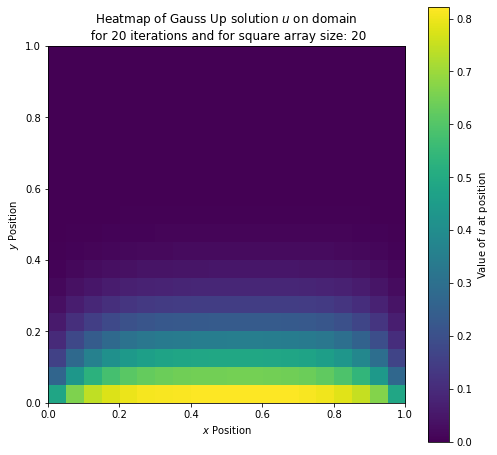

Time to run with: 0.26676392555236816


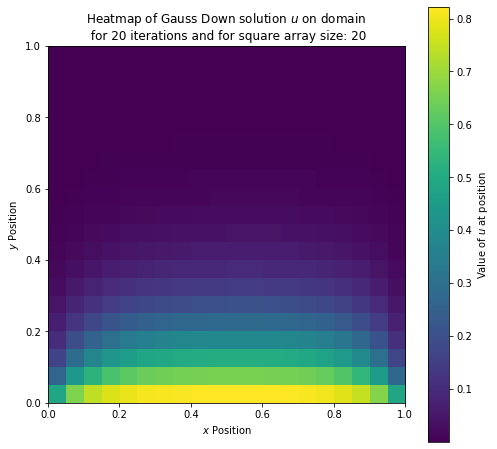

In [15]:
plot_laplace_CG_Gauss_Numba_UP(20,20)
plot_laplace_CG_Gauss_Numba_DOWN(20,20)

For a single iteration a variance in the result is visible but once you start to increase the iterations to a reasonable value the difference becomes unoticable in the plot. Also interesting to note is that the method of decreasing index value actually operates faster. This is lkeley due to the starting point being at the boundary where there is a non-zero value.

We now modify the OpenCL based class for the Jacobi iteration to implement the relaxed Gauss Seidel iteration (ths is done in two ways, one for each sweep direction up/down). Due to the nature of the parralelisation that OpenCL is able to do inorder to implement a Gauss Seiddel like method we need to restrict the 'looping' of OpenCL by hard coding a loop into the kernel. Ths is effectively 'tying a hand behind the back' of OpenCL so that only a given row is parallelised.

In [16]:
class Laplacian_OpenCL_Gauss_Seidel_Down(LinearOperator): 
    '''This class represents a Gauss Seidel Iteration.'''
    def __init__(self,m):
        '''Constructor for creating Gauss iteraton instance.'''
        
        self.m = m
        self.shape = (m * m, m * m)

        # Setup OpenCL.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        # OpenCL kernel for 5 point laplician 
        # stencil approximation.
        self.prg = cl.Program(self.ctx, """
            __kernel void operator(const int N,
                                      __global float* entry,
                                      __global float* results) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);
                
                
                // This loop is for constraining OpenCL to 
                // to operate over an individual row
                for (int row_constraint = 0; row_constraint<N;row_constraint++){
                if(row_constraint==i){
                
                float mid = entry[N*i + j];
                float top = entry[N*(i-1) + j];
                float bottom = entry[N*(i+1) + j];
                float minus = entry[N*i + j-1];
                float plus = entry[N*i + j+1];
                
                if (i == 0){
                    top = 0;
                }
                if (i == (N-1)){
                    bottom = 1;
                }
                if (j == 0){
                    minus = 0;
                }
                if (j == (N-1)){
                    plus = 0;
                }
                
                results[N*i + j] = (
                top + bottom + minus + plus)*0.25;
                entry[N*i + j] = (
                top + bottom + minus + plus)*0.25;
                }
                }
            }
            """).build()
        
        
    def _matvec(self,line_data):
        '''This function represents the matrix multiplication.'''

        # Setting up class data type.
        self.dtype = line_data.dtype
        
        N = np.int32(self.m)
        
        # Setting up array for results. 
        results = np.zeros_like(line_data).astype('float32')
        
        ## Setting up on device storage.
        # First buffer is set to RW so values can be updated.
        grid_device = cl.Buffer(
            self.ctx, self.mf.READ_WRITE | self.mf.COPY_HOST_PTR, hostbuf=line_data)
        results_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, line_data.nbytes)

        linoperator = self.prg.operator

        ts = 1
        
        # Running OpenCL program for given inputs.
        event = linoperator(
            self.queue, (N, N), (ts, ts), N, grid_device, results_device)
        event.wait()

        cl.enqueue_copy(self.queue, results, results_device)
        event.wait()
        self.queue.finish()

        return results
    
    def create(self):
        '''Function to create instant of object as scipy LinearOperator.'''
            
        return LinearOperator((self.m,self.m),matvec=self._matvec)

In [17]:
def plot_laplace_CG_Gauss_Down(iterations,M):
    '''Function to compute and plot solution u
    from the OpenCL accelerated Gauss Seiddel
    Down iteration.'''
    
    laplacian = Laplacian_OpenCL_Gauss_Seidel_Down(M)
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M)

    initial_guess = np.zeros((M*M),dtype='float32')
    
    with Timer() as t:

        for n in range(0,iterations):
            solution_n = laplacian._matvec(initial_guess)
            initial_guess = solution_n

    print("Time to run with: {0}".format(t.interval))
    
    plt.figure(figsize=(8,8))
    plt.imshow(
        initial_guess.reshape(M,M), cmap='viridis',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of Gauss Down solution $u$ on domain \n for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()

In [18]:
class Laplacian_OpenCL_Gauss_Seidel_Up(LinearOperator): 
    '''This class represents a Gauss Seidel iteraton.'''
    def __init__(self,m):
        '''Constructor for creating Gauss iteration instance.'''
        

        self.m = m
        self.shape = (m * m, m * m)

        # Setup OpenCL.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        # OpenCL kernel for 5 point laplician 
        # stencil approximation.
        self.prg = cl.Program(self.ctx, """
            __kernel void operator(const int N,
                                      __global float* entry,
                                      __global float* results) {

                // Thread identifiers
                const int i = N-1-get_global_id(0);
                const int j = get_global_id(1);
                
                
                // This loop is for constraining OpenCL to 
                // to operate over an individual row
                for (int row_constraint = N-1; row_constraint>=0;row_constraint--){
                if(row_constraint==i){
                
                float mid = entry[N*i + j];
                float top = entry[N*(i-1) + j];
                float bottom = entry[N*(i+1) + j];
                float minus = entry[N*i + j-1];
                float plus = entry[N*i + j+1];
                
                if (i == 0){
                    top = 0;
                }
                if (i == (N-1)){
                    bottom = 1;
                }
                if (j == 0){
                    minus = 0;
                }
                if (j == (N-1)){
                    plus = 0;
                }
                
                results[N*i + j] = (
                top + bottom + minus + plus)*0.25;
                entry[N*i + j] = (
                top + bottom + minus + plus)*0.25;
                }
                }
            }
            """).build()
        
        
    def _matvec(self,line_data):
        '''This function represents the matrix multiplication.'''

        # Setting up class data type.
        self.dtype = line_data.dtype
        
        N = np.int32(self.m)
        
        # Setting up array for results. 
        results = np.zeros_like(line_data).astype('float32')
        
        # Setting up on device storage.
        grid_device = cl.Buffer(
            self.ctx, self.mf.READ_WRITE | self.mf.COPY_HOST_PTR, hostbuf=line_data)
        results_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, line_data.nbytes)

        linoperator = self.prg.operator

        ts = 1
        
        # Running OpenCL program for given inputs.
        event = linoperator(
            self.queue, (N, N), (ts, ts), N, grid_device, results_device)
        event.wait()

        cl.enqueue_copy(self.queue, results, results_device)
        event.wait()
        self.queue.finish()

        return results
    
    def create(self):
        '''Function to create instant of object as scipy LinearOperator.'''
            
        return LinearOperator((self.m,self.m),matvec=self._matvec)

In [19]:
def plot_laplace_CG_Gauss_Up(iterations,M):
    '''Function to compute and plot solution u
    from the OpenCL accelerated Gauss Seiddel
    Up iteration.'''
    
    laplacian = Laplacian_OpenCL_Gauss_Seidel_Up(M)
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M)
 
    initial_guess = np.zeros((M*M),dtype='float32')
    
    with Timer() as t:

        for n in range(0,iterations):
            solution_n = laplacian._matvec(initial_guess)
            initial_guess = solution_n
    print("Time to run with: {0}".format(t.interval))
    
    
    plt.figure(figsize=(8,8))
    plt.imshow(
        initial_guess.reshape(M,M), cmap='viridis',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of Gauss Up solution $u$ on domain \n for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()

We then run both of these and plot the results.

Time to run with: 0.004605293273925781


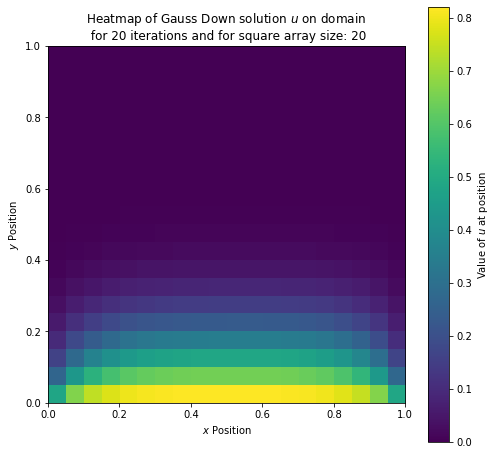

Time to run with: 0.0037386417388916016


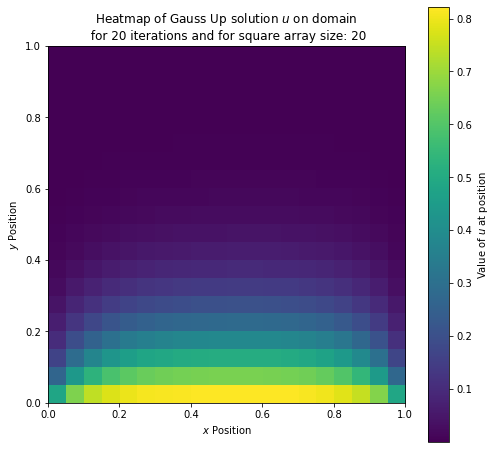

In [20]:
plot_laplace_CG_Gauss_Down(20,20)
plot_laplace_CG_Gauss_Up(20,20)

### Comparison of Gauss Numba vs OpenCL

In [21]:
def plot_Gauss_comparison(iterations,M):
    '''Function to compare convergence go Gauss
    in Numba vs OpenCL implementations.'''
    
    laplacian = Laplacian_OpenCL_Gauss_Seidel_Up(M)
    
    check = Laplacian_OpenCL(M)
    
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M)
   
    initial_guess = np.zeros((M*M),dtype='float32')
    
    residual1=[]
    residual2=[]
    
    with Timer() as t:

        for n in range(0,iterations):
            solution_n = laplacian._matvec(initial_guess)
            initial_guess = solution_n
            
            ##Tweaked residual call,no normalisation
            residual1.append(residual_calc(check._matvec(solution_n)+1,1))
    print("Time to run with OpenCL: {0}".format(t.interval))
    
    
    initial_guess = np.zeros((M*M),dtype='float32')
    
    with Timer() as t:

        for n in range(0,iterations):
            solution_n = gauss_seiddel_UP(M,initial_guess)
            initial_guess = solution_n
            
            ##Tweaked residual call,no normalisation
            residual2.append(residual_calc(check._matvec(solution_n)+1,1))
    print("Time to run with Numba: {0}".format(t.interval))
    
    
    
    
    plt.figure()
    plt.plot(np.linspace(1,iterations,num=len(residual1)),residual1,label='OpenCL')
    plt.plot(np.linspace(1,iterations,num=len(residual2)),residual2,label='Numba')
    plt.axhline(y=0,color='m')
    plt.title(
        'Convergence comparison of $u$ across iterations on domain \n for max '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('Iterations')
    plt.ylabel('Unormalised Residual')
    plt.legend()
    plt.yscale('log')

Time to run with OpenCL: 0.17241144180297852
Time to run with Numba: 0.09456253051757812


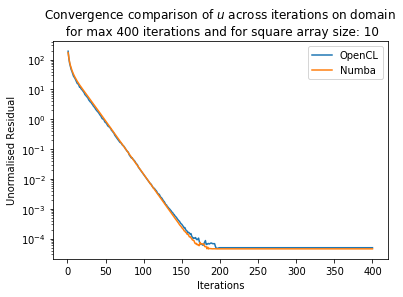

In [22]:
plot_Gauss_comparison(400,10)

To be able to compute the residual, the function call was done in such a way so as to not normalise with respect to b, inorder to prevent a divide by zero error. Thus the plot is of the unormalised residual, but this is sufficient as it still shows the same trend.

From the plot it can be seen that the OpenCL method has lower residuals and thus converges more rapidly than Numba. That said though from the timings printed before the plot it can been that Numba runs faster than OpenCL and would therefore converge 'quicker' in a real world performance sense. It can als be inferred from the 'floor' of the plot that both methods converge around the same number of iterations (~[150,200]).

# Question 2
<a id="question2"></a>

We first write a class for constructing our system $Ax=b$. The class neads to create both $A$ and $b$, whereby the stencil, the L-shaped domain and the recognition of the boundary conditons are encoded into $A$. The boundary condition values themselves are encoded into $b$.

We can define the constuction of $A$ as 
\begin{equation}
A=
\begin{bmatrix}
B & -I \\ 
-I & B
\end{bmatrix}
\end{equation}

Where:
\begin{equation}
B=
\begin{bmatrix}
4 & -1 \\ 
-1 & 4
\end{bmatrix}
\end{equation}
(for larger sizes, elements only on zero on main diagional and both sub diagonals $(k=0,1,-1))$ and,
\begin{equation}
I=
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix}
\end{equation}

Our matrix $b$ here is defined as $b=0$.

Important!!!
$h=\frac{1}{M-1}$

To recognise the boundary conditons, a given row (corresponding to a point in b) is set to zero while the diagonal element on tht given row is set to one. The same method is used for setting the out of domain area on the L, except the diagoanl element is left as zero.

To keep storage resources to a minimum the matrix A is first built with COO and than cast to CSR. Add of elemetns is done first in COO format to prevent varying the sparsity of CSR. 

In [23]:
class matrix_A():
    '''Class for representing system Ax=b'''
    def __init__(self,m):
        '''Constructor for creating A and 
        common variables across system.'''
        
        self.m=m #+2
        self.m_orig = m #+2
        self.h = (1/(self.m-1))
        self.h2 = (1/(self.m-1))**2
        
        #define B matrix
        self.B = sp.sparse.coo_matrix((self.m, self.m), dtype=np.int8)#main diagonal of 4s #sub diagonals of -1
        self.B.setdiag(np.ones((self.m))*4*self.h2,k=0)
        self.B.setdiag(np.ones((self.m))*-1*self.h2,k=-1)
        self.B.setdiag(np.ones((self.m))*-1*self.h2,k=1)
        #define Identity matrix
        self.I = sp.sparse.coo_matrix((self.m, self.m), dtype=np.int8)
        self.I.setdiag(np.ones((self.m))*-1*self.h2,k=0)
        
        #define A matrix
        dummy = sp.sparse.coo_matrix((self.m, self.m), dtype=np.int8)
        dummy.setdiag(np.ones((self.m))*1,k=1)
        dummy.setdiag(np.ones((self.m))*1,k=-1)
        self.A = sp.sparse.kron(sp.sparse.identity(self.m),self.B,format="csr")+sp.sparse.kron(dummy,self.I,format="csr")
        
        
        #### Encoding A to recognise boundary conditions and out of domain.
       
        ##CORRECT#top boundary
        for w in np.arange((0),(self.m_orig-1+1),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
        
        ##CORRECT#right hand boundary
        for w in np.arange((1),(((self.m_orig)+1)),dtype='int'):
            self.A[self.m_orig*w-1,:] = 0
            self.A[self.m_orig*w-1,self.m_orig*w-1] = 1
        
        ##CORRECt#left hand boundary
        for w in np.arange((0),(self.m_orig-1+1),dtype='int'):
            self.A[w*self.m_orig,:] = 0
            self.A[w*self.m_orig,w*self.m_orig] = 1
            
        ##CORRECT#bottom boundary
        for w in np.arange(((self.m_orig-1)*self.m_orig),((self.m_orig**2)-self.m_orig/2),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
            
        ##CORRECT#Inner corner boundary top
        for w in np.arange(((self.m_orig)*(self.m_orig/2-1)+self.m_orig/2-1),((self.m_orig)*(self.m_orig/2-1)+self.m_orig),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
            
        ##CORRECT#Inner corner boundary side
        for w in np.arange((self.m_orig/2-1),(self.m_orig-1+1),dtype='int'):
            self.A[w*self.m_orig+self.m_orig/2-1,:] = 0
            self.A[w*self.m_orig+self.m_orig/2-1,w*self.m_orig+self.m_orig/2-1] = 1
            
           
        # Specifiying part outside domain:Empty part of L shape/
        for k in np.arange((self.m_orig/2),((self.m_orig-1+1)),dtype='int'):
            self.A[self.m_orig*k+k,:] = 0
            #self.A[self.m_orig*k+k,self.m_orig*k+k] = 23
            for z in range(int(self.m_orig/2),int(self.m_orig)):
                self.A[self.m_orig*k+z,:] = 0
                self.A[self.m_orig*k+z,self.m_orig*k+z] = 0
            
    def output(self):
        '''Function to output matrix A in CSR format.'''
        return self.A

    
    def check_output_is_csr(self):
        '''Convenience function to check that
        the output of A is in CSS format.'''
        print(sp.sparse.isspmatrix_csr(self.A))
    

    def b_of_system(self):
        '''Function to create b part of system.'''
        
        b = np.zeros((self.m, self.m),dtype=np.float64)
        
        x0 = -3
        y0 = -3
    
        for i in range(int(self.m/2)):
            for j in range(self.m):
                b[i, j] = 0.5*np.log((i*self.h-x0)**2+(j*self.h-y0)**2)
            
        for i in range(int(self.m/2), self.m):
            for j in range(int(self.m/2)):
                b[i, j] = 0.5*np.log((i*self.h-x0)**2+(j*self.h-y0)**2)
            
        b[1 : int(self.m/2) - 1, 1 : self.m - 1] = 0.0
        b[1 : self.m - 1, 1 : int(self.m/2) - 1] = 0.0
        
        return b.flatten()
    
    def u_guess(self,factor):
        '''Function to create a guess for the solver of this system.'''
        return np.ones(((self.m)*(self.m)))*factor

In [24]:
def plot_laplace_CG_L(iterations,M):
    '''Function to compute and plot solution u.'''
    
    A = matrix_A(M)
    
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M) #pad_overwrite(xk,0.5,M) 
        
    # CG solver.
    with Timer() as t:

        solution_L,info = cg(
            A.output(),A.b_of_system(),
            maxiter = iterations, callback = cg_call_back,x0=A.u_guess(0.5))
    
    print("Time to run with: {0}".format(t.interval))
    
    
    plt.figure(figsize=(8,8))
    plt.imshow(solution_L.reshape(M,M), cmap='viridis',extent=[-1,1,-1,1]) #solution_L.reshape(M+2, M+2)
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of solution $u$ with boundary conditions on \n domain for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$x$ Position')
    plt.ylabel('$y$ Position')
    plt.show()

/home/duncan/anaconda3/envs/hpc/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Time to run with: 0.01837944984436035


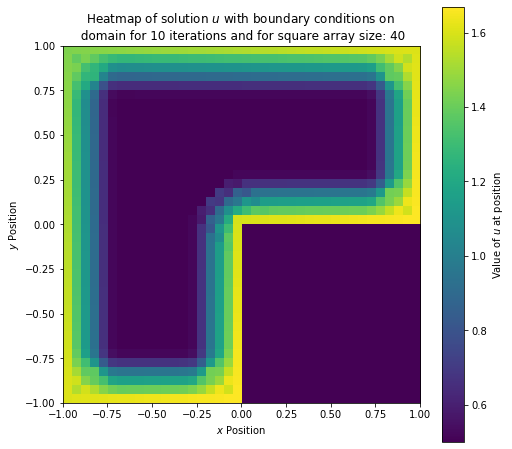

In [25]:
plot_laplace_CG_L(10,40)

N.B. Solution sometimes is approximating the value of the boundary condition (i.e. changing the boundary condition will change the result), if the boundary is constant. Solution shown here is only partial just to visualise the behaviour, to view the actually completed approximate solution more iterations are required. Which is done below.

Time to run with: 0.08904719352722168


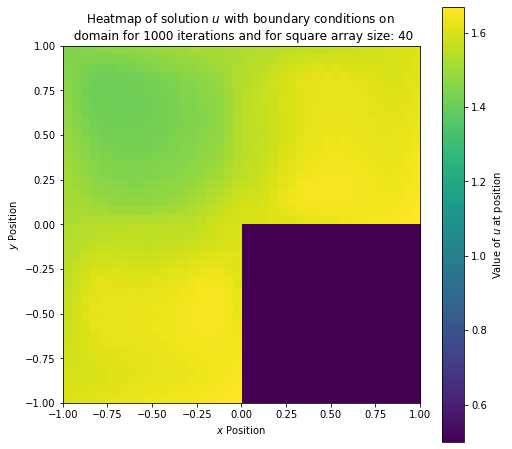

In [26]:
plot_laplace_CG_L(1000,40)

In [27]:
def plot_laplace_CG_L_Convergence_iter(iterations,M):
    '''Function to compute x over different iterations'''
    
    A = matrix_A(M)

    residual = []
    initial_guess = []
    
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M) 
        
    with Timer() as t:

        
        for n in range(1,iterations):
            solution_n,info = cg(
            A.output(),A.b_of_system(),
            maxiter = n, callback = cg_call_back,x0=A.u_guess(0.5))
            initial_guess = solution_n


            residual.append(residual_calc(A.output()*solution_n,A.b_of_system()))
    print("Time to run with: {0}".format(t.interval)) 

    plt.figure()
    plt.axhline(y=0,color='m')
    plt.plot(np.linspace(1,iterations,num=len(residual)),residual)
    plt.title(
        'Plot of solution convergence for maximum '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('Iterations ran')
    plt.ylabel('Residual')
    plt.yscale('log')
    plt.xscale('log')
   

Time to run with: 1.3986403942108154


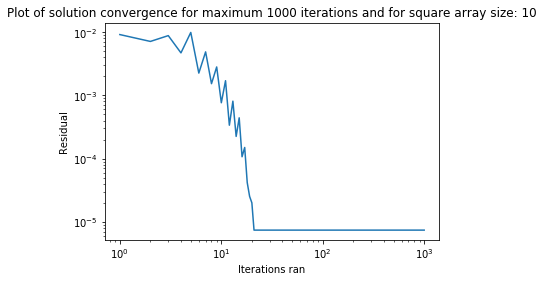

In [28]:
plot_laplace_CG_L_Convergence_iter(1000,10)

From the plot it can be seen the solution only converges with sufficiently high iteration numbers. There also appears to be a 'critical convergence region' where the residual drop off suddenly, but then is level for any increase in iterations. Inidicating any further iterations do not imporve the end result. (Ths can be thought of like there is a heat source that is diffucing in the domain, once thie critical iteration number is reached the heat in the domain is at equlibrium with the boundary and so no further diffusion will take place.

In [29]:
def plot_laplace_CG_L_Convergence_points(iterations,M):
    '''Function to compute x over different
    number of discretisation points.'''
    
    residual = []
    initial_guess = []
     
    with Timer() as t:
    
        for n in range(2,M,2):

            A = matrix_A(n)

            def cg_call_back(xk):
                '''Function used by CG solver for iterating with.'''
                data = xk.reshape(n, n)

            solution_n,info = cg(
            A.output(),A.b_of_system(),
            maxiter = iterations, callback = cg_call_back,x0=A.u_guess(0.5))
            initial_guess = solution_n

            residual.append(residual_calc(A.output()*solution_n,A.b_of_system()))
        
    print("Time to run with: {0}".format(t.interval))

    plt.figure()
    plt.axhline(y=0,color='m')
    plt.plot(np.linspace(4,M,num=len(residual)),residual)
    plt.title(
        'Plot of solution convergence for '
        +str(iterations)+' iterations and for maximum square array size: '+str(M))
    plt.xlabel('Array size')
    plt.ylabel('Residual')
    #plt.yscale('log')
    #plt.xscale('log')

Time to run with: 27.00896382331848


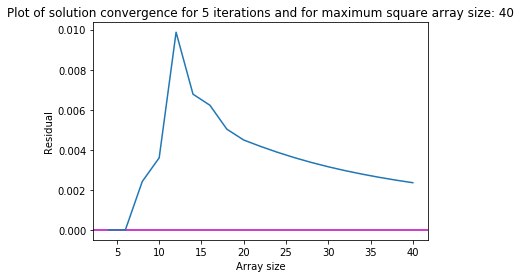

In [30]:
plot_laplace_CG_L_Convergence_points(5,40)

From the plot above we can see how the convergence of the solver for a fixed iteration nummber varies with the number of discretisation points. The plot implies that the solution on a given array size converges at a number of discretisation points, any increase in the array for the same iteration number causes an equivelant increase in the residual. This means for an increase in the number of discretisation points, an increase in the number of iterations is required to approach as 'good' of a solution.

We now can try and imporve the formance of the solver (make it require less iterations to converge) by applying a preconditioner to our matrix A. While this may not neccesarrily produce a correct output faster it should for the same size require less computation to approximate the solution of the system.

Because it would seem our matrix A is singular for many sizes it is necessary to add a slight deviation the diagonal elements inorder for the inverse to exist.

In [31]:
def plot_laplace_CG_L_Conditioner(iterations,M):
    '''Function to compute and plot solution u
    with preconditioning applied.'''
    
    A = matrix_A(M)

    # Stop A being singular for preconditioning
    A_non_singular = A.output()
    A_non_singular.setdiag(A_non_singular.diagonal()+0.00000001)
    
    B = spilu(A_non_singular)

    # Make linear operator for preconditoner
    Mz = lambda r: B.solve(r)
    Minv = LinearOperator(A_non_singular.get_shape(), Mz)
    
    #print(A_non_singular.get_shape())

    
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M) #pad_overwrite(xk,0.5,M) 
    
    with Timer() as t:

        # CG solver with preconditoner   
        solution_L,info = cg(
            A_non_singular,A.b_of_system(),
            maxiter = iterations, callback = cg_call_back,x0=A.u_guess(0.5),M=Minv)


    print("Time to run with: {0}".format(t.interval))
    
    plt.figure(figsize=(8,8))
    plt.imshow(solution_L.reshape(M,M), cmap='viridis',extent=[-1,1,-1,1]) #solution_L.reshape(M+2, M+2)
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of solution $u$ with pre conditioning and \n boundary condition on domain \n for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$y$ Position')
    plt.ylabel('$x$ Position')
    plt.show()

/home/duncan/anaconda3/envs/hpc/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Time to run with: 0.0013048648834228516


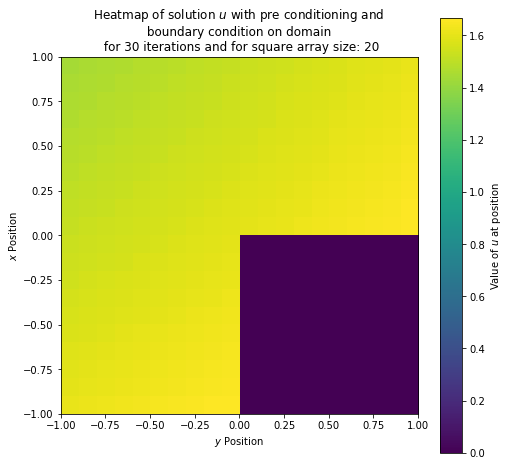

In [32]:
plot_laplace_CG_L_Conditioner(30,20)

The preconditioning appears to work but to see the benefit of this it must be compared to a non preconditioned solution.

Time to run with: 0.005439281463623047


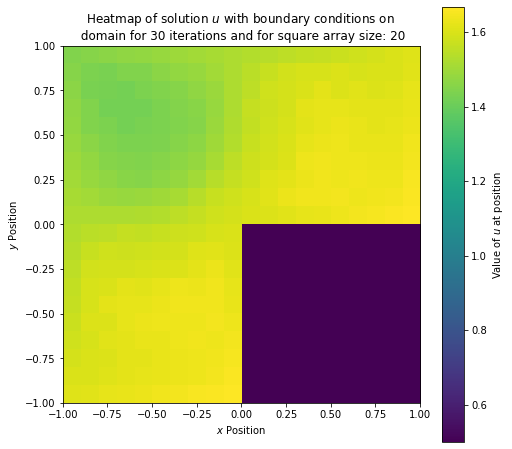

Time to run with: 0.002536296844482422


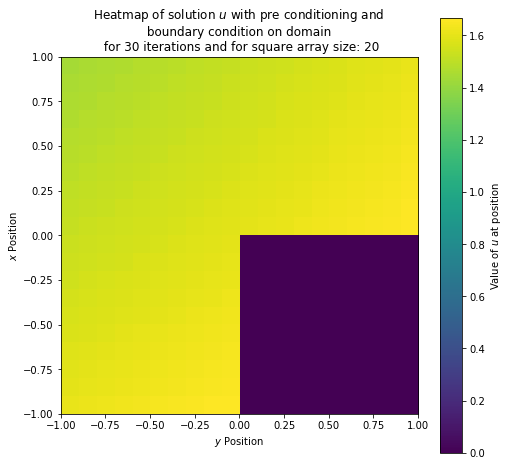

In [33]:
plot_laplace_CG_L(30,20)
plot_laplace_CG_L_Conditioner(30,20)

As can be seen from the two plots above the un preconditioned method has not reached the solution in the given number of iterations, but the preconditioned one has reached the solution for the same number of iterations. This confirms that the precondtioning causes the solver to converge more quickly, and if you examine the time to compute that was printed out the preconditioned one is faster as effectively the system of simultaneous equatons the solver is solving is that much smaller. These timings however do not account for the computation time to find the factorisation of A.

We can then investigate how different drop values in the factorisation affect the convergence.

In [34]:
## Investigate how drop factor changes the convergence
def plot_laplace_CG_L_Conditioner_Drop(iterations,M,step):
    '''Function to compute and plot solution u for varying
    drop values on factorisaton LU.'''
    
    A = matrix_A(M)
    initial_guess = []
    residual = []
    

    # Stop A being singular for preconditioning
    A_non_singular = A.output()
    A_non_singular.setdiag(A_non_singular.diagonal()+0.00000001)
    
    min_drop = 0
    max_drop = 1
    step_drop = step
    
    with Timer() as t:

        for n in np.arange(min_drop,max_drop,step_drop):
            B = spilu(A_non_singular,drop_tol=n)

            # Make linear operator for preconditoner
            Mz = lambda r: B.solve(r)
            Minv = LinearOperator(A_non_singular.get_shape(), Mz)


            def cg_call_back(xk):
                '''Function used by CG solver for iterating with.'''
                data = xk.reshape(M, M) #pad_overwrite(xk,0.5,M) 

            # CG solver with preconditoner   
            solution_n,info = cg(
                A.output(),A.b_of_system(),
                maxiter = iterations, callback = cg_call_back,x0=A.u_guess(0.5),M=Minv)

            initial_guess = solution_n


            residual.append(np.linalg.norm(solution_n))
        
    
    print("Time to run with: {0}".format(t.interval))
    
    plt.figure()
    plt.axhline(y=0,color='m')
    plt.plot(np.linspace(min_drop,max_drop,num=len(residual)-1),np.diff(residual))
    plt.title(
        'Plot of solution convergence for '
        +str(iterations)+' iterations \n and for maximum square array size: '+str(M))
    plt.xlabel('SPILU Drop value')
    plt.ylabel('Difference in solutions')
    #plt.yscale('log')
    plt.xscale('log')

Time to run with: 3.1752705574035645


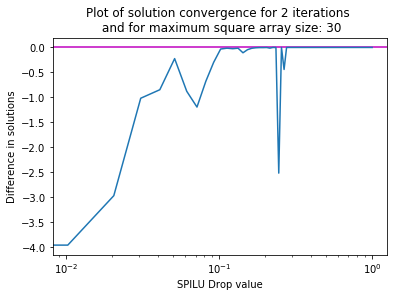

In [35]:
plot_laplace_CG_L_Conditioner_Drop(2,30,0.01)

The plot above shows how for low drop values the preconditioning isn't very effective. The effective gradually improves with the increase in the drop value as the difference in the solutions converges to zero. However as the drop value begins to approach one the solution will sometimes not converge, implying that some middle value between zero and one is most appropriate. By default spilu in scipy uses 1E-4.